# 第3章

## 分類問題　ー機械学習ライブラリscikit-learnの活用ー

In [1]:
from sklearn import datasets
import numpy as np

In [2]:
# Irisデータセットをロード
iris = datasets.load_iris()
# 3, 4列目の特徴量を抽出
X = iris.data[:, [2, 3]]
# クラスラベルを取得
y = iris.target
# 一意なクラスラベルを出力
print("Class labels:", np.unique(y))

Class labels: [0 1 2]


In [3]:
from sklearn.model_selection import train_test_split
# トレーニングデータとテストデータに分割
# 全体の30%をテストデータにする
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=1, stratify=y)

In [4]:
print("Labels counts in y:", np.bincount(y))
print("Labels counts in y_train:", np.bincount(y_train))
print("Labels counts in y_test:", np.bincount(y_test))

Labels counts in y: [50 50 50]
Labels counts in y_train: [35 35 35]
Labels counts in y_test: [15 15 15]


In [5]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
# トレーニングデータの平均と標準偏差を計算
sc.fit(X_train)
# 平均と標準偏差を用いて標準化
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)

In [6]:
from sklearn.linear_model import Perceptron
# エポック数40、　学習率0.1でパーセプロトンのインスタンスを作成
ppn = Perceptron(n_iter=40, eta0=0.1, random_state=1)
# トレーニングデータをモデルに適合させる
ppn.fit(X_train_std, y_train)

/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Perceptron(alpha=0.0001, class_weight=None, early_stopping=False, eta0=0.1,
      fit_intercept=True, max_iter=None, n_iter=40, n_iter_no_change=5,
      n_jobs=None, penalty=None, random_state=1, shuffle=True, tol=None,
      validation_fraction=0.1, verbose=0, warm_start=False)

In [7]:
# テストデータで予測を実施
y_pred = ppn.predict(X_test_std)
# 誤分類のサンプルの個数を表示
print("Misclassified samples: %d" % (y_test != y_pred).sum())

Misclassified samples: 9


In [8]:
from sklearn.metrics import accuracy_score
# 分類の正解率を表示
print("Accuracy: %.2f" % accuracy_score(y_test, y_pred))

Accuracy: 0.80


In [9]:
print("Accuracy: %.2f" % ppn.score(X_test_std, y_test))

Accuracy: 0.80


In [10]:
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt

def plot_decision_regions(X, y, classifier, test_idx=None, resolution=0.02):
    
    # マーカーとカラーマップの準備
    markers = ("s", "x", "o", "^", "v")
    colors = ("red", "blue", "lightgreen", "gray", "cyan")
    cmap = ListedColormap(colors[:len(np.unique(y))])
    
    # 決定領域のプロット
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    # グリッドポイントの作成
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                                              np.arange(x2_min, x2_max, resolution))
    # 各特徴量を1次元配列に変換して予測を実行
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    # 予測結果を元のグリッドポイントのデータサイズに変換
    Z = Z.reshape(xx1.shape) 
    # グリッドポイントの等高線のプロット
    plt.contourf(xx1, xx2, Z, alpha=0.3, cmap=cmap)
    # 軸の範囲の設定
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())
    
    # クラスごとにサンプルをプロット
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], y=X[y == cl, 1],
                            alpha=0.8,
                            c=colors[idx],
                            marker=markers[idx],
                            label=cl,
                            edgecolor="black")
    
    # テストサンプルを目立たせる（点を○で表示）
    if test_idx:
        X_test, y_test = X[test_idx, :], y[test_idx]
        plt.scatter(X_test[:, 0], X_test[:, 1],
                            c="",
                            edgecolor="black",
                            alpha=1.0,
                            linewidth=1,
                            marker="o",
                            s=100,
                            label="test set")

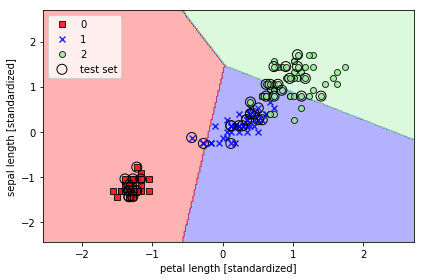

In [11]:
# トレーニングデータとテストデータの特徴量を行方向に結合
X_combined_std = np.vstack((X_train_std, X_test_std))
# トレーニングデータとテストデータのクラスラベルの結合
y_combined = np.hstack((y_train, y_test))
# 決定領域のプロット
plot_decision_regions(X=X_combined_std, y=y_combined, classifier=ppn,
                                        test_idx=range(105, 150))
# 軸ラベルの設定
plt.xlabel("petal length [standardized]")
plt.ylabel("sepal length [standardized]")
#　凡例の設定
plt.legend(loc="upper left")
# グラフを表示
plt.tight_layout()
plt.show()

## 3.3　ロジスティック回帰を使ってクラスの確率を予測するモデルの構築

### 3.3.1　ロジスティック回帰の直感的知識と条件付き確立

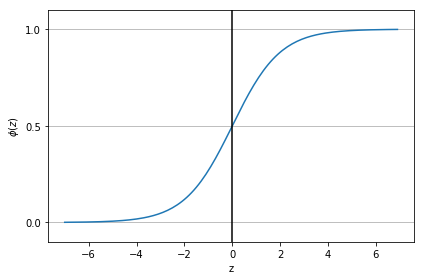

In [12]:
import matplotlib.pyplot as plt
import numpy as np

# シグイモイド関数を定義
def sigmoid(z):
    return 1.0 / (1.0 + np.exp(-z))

# 0.1間隔で-7以上7未満のデータを生成
z = np.arange(-7, 7, 0.1)
# 生成したデータでシグモイド関数を実行
phi_z = sigmoid(z)
# 元のデータとシグモイド関数の出力をプロット
plt.plot(z, phi_z)
# 垂直線を追加（z=0）
plt.axvline(0.0, color="k")
# y軸の上限・下限を設定
plt.ylim(-0.1, 1.1)
# 軸のラベルを設定
plt.xlabel("z")
plt.ylabel("$\phi (z)$")
# y軸のメモリを追加
plt.yticks([0.0, 0.5, 1.0])
# Axesクラスのオブジェクトを取得
ax = plt.gca()
# y軸のメモリに合わせて水平グリッド線を追加
ax.yaxis.grid(True)
# グラフを表示
plt.tight_layout()
plt.show()

### 3.3.2　ロジスティック関数の重みの学習

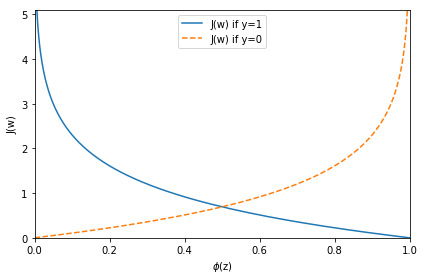

In [13]:
# y=1のコストを計算する関数
def cost_1(z):
    return -np.log(sigmoid(z))

# y=0のコストを計算する関数
def cost_0(z):
    return -np.log(1 - sigmoid(z))

# 0.1間隔で-10以上10未満のデータを生成
z = np.arange(-10, 10, 0.1)
# シグモイド関数を実行
phi_z = sigmoid(z)
# y=1のコストを計算する関数を実行
c1 = [cost_1(x) for x in z]
# 結果をプロット
plt.plot(phi_z, c1, label="J(w) if y=1")
# y=0のコストを計算する関数を実行
c0 = [cost_0(x) for x in z]
# 結果をプロット
plt.plot(phi_z, c0, linestyle="--", label="J(w) if y=0")
# y軸とx軸の上限・下限を設定
plt.ylim(0.0, 5.1)
plt.xlim([0, 1])
# 軸のラベルを設定
plt.xlabel("$\phi$(z)")
plt.ylabel("J(w)")
# 凡例を設定
plt.legend(loc="upper center")
# グラフを表示
plt.tight_layout()
plt.show()

### 3.3.3　ADALINE実装をロジスティック回帰のアルゴリズムに変換する

In [14]:
class LogisticRegressionGD(object):
    """勾配降下法に基づくロジスティック回帰分類器
    
    パラメータ
    ---------------
    eta : float
        学習率（0.0より大きく1.0以下の値）
    n_iter : int
        トレーニングデータのトレーニング回数
    random_state : int
        重みを初期化させるための乱数シード
    
    属性
    ---------------
    w_ : 1次元配列
        適合後の重み
    cost_ : リスト
        各エポックでの誤差平方和コスト関数
    
    """
    
    def __init__(self, eta=0.05, n_iter=100, random_state=1):
        # 学習の初期化
        self.eta = eta
        # トレーニング回数の初期化
        self.n_iter = n_iter
        # 乱数シードを固定するrandom_state
        self.random_state = random_state
        
    def fit(self, X, y):
        """トレーニングデータに適合させる
        
        パラメータ
        ---------------
        X : {配列のような構造}, shape = [n_sample, n_feature]
            トレーニングデータ
            n_sampleはサンプルの個数、n_featureは特徴量の個数
        y : 配列のようなデータ構造, shape ~ [n_sample]
            目的変数
        
        戻り値
        -----------
        self : object
        """
        
        rgen = np.random.RandomState(self.random_state)
        self.w_ = rgen.normal(loc=0.0, scale=0.01, size=1 + X.shape[1])
        self.cost_ = []
        
        # トレーニング回数分トレーニングデータを反復処理
        for i in range(self.n_iter):
            net_input = self.net_input(X)
            output = self.activation(net_input)
            errors = (y - output)
            self.w_[1:] += self.eta * X.T.dot(errors)
            self.w_[0] += self.eta * errors.sum()
            
            # 誤差平方和のコストではなくロジスティック回帰のコストを計算することに注意
            cost = -y.dot(np.log(output)) - ((1 - y).dot(np.log(1 - output)))
            # エポックごとのコストを格納
            self.cost_.append(cost)
        return self
    
    def net_input(self, X):
        """総入力を計算"""
        return np.dot(X, self.w_[1:]) + self.w_[0]
    
    def activation(self, z):
        """ロジスティックシグモイド活性化関数を計算"""
        return 1. / (1. + np.exp(-np.clip(z, -250, 250)))
    
    def predict(self, X):
        """1ステップ後のクラスラベルを返す"""
        return np.where(self.net_input(X) >= 0.0, 1, 0)
    

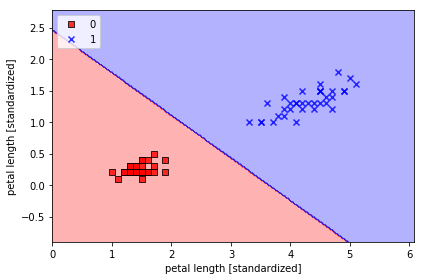

In [15]:
X_train_01_subset = X_train[(y_train == 0) | (y_train == 1)]
y_train_01_subset = y_train[(y_train == 0) | (y_train == 1)]
# ロジスティック回帰のインスタンスを作成
lrgd = LogisticRegressionGD(eta=0.05, n_iter=1000, random_state=1)
# モデルをトレーニングデータの適合させる
lrgd.fit(X_train_01_subset, y_train_01_subset)
# 決定領域をプロット
plot_decision_regions(X=X_train_01_subset,
                                        y=y_train_01_subset,
                                        classifier=lrgd)
# 軸のラベル設定
plt.xlabel("petal length [standardized]")
plt.ylabel("petal length [standardized]")
# 凡例を設定
plt.legend(loc="upper left")
# グラフを表示
plt.tight_layout()
plt.show()

### 3.3.4　scikit-learnを使ったロジスティック回帰モデルのトレーニング

/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


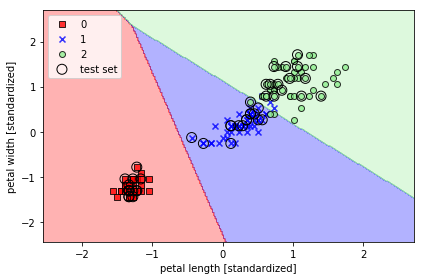

In [16]:
from sklearn.linear_model import LogisticRegression
# ロジスティック回帰のインスタンスを作成
lr = LogisticRegression(C=100.0, random_state=1)
# トレーニングデータをモデルに適合させる
lr.fit(X_train_std, y_train)
# 決定境界をプロット
plot_decision_regions(X_combined_std, y_combined, classifier=lr,
                                        test_idx=range(105, 150))
#　軸のラベル設定
plt.xlabel("petal length [standardized]")
plt.ylabel("petal width [standardized]")
# 凡例を設定
plt.legend(loc="upper left")
# グラフを表示
plt.tight_layout()
plt.show()

In [17]:
lr.predict_proba(X_test_std[:3, :])

array([[3.17983737e-08, 1.44886616e-01, 8.55113353e-01],
       [8.33962295e-01, 1.66037705e-01, 4.55557009e-12],
       [8.48762934e-01, 1.51237066e-01, 4.63166788e-13]])

In [18]:
lr.predict_proba(X_test_std[:3, :]).sum(axis=1)

array([1., 1., 1.])

In [19]:
lr.predict_proba(X_test_std[:3, :]).argmax(axis=1)

array([2, 0, 0])

In [20]:
lr.predict(X_test_std[:3, :])

array([2, 0, 0])

In [21]:
lr.predict(X_test_std[0, :].reshape(1, -1))

array([2])

### 3.3.5　正則化による過学習への対処

/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_mod

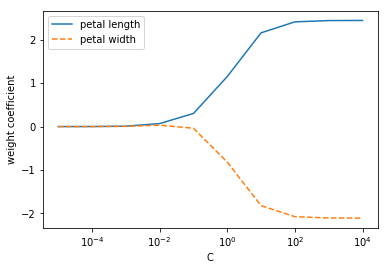

In [22]:
# 空のリストを生成（重み係数、逆正則化パラメータ）
weights, params = [], []
# 10個の逆正則化パラメータに対応するロジスティック回帰モデルをそれぞれ処理
for c in np.arange(-5, 5):
    lr = LogisticRegression(C=10.**c, random_state=1)
    lr.fit(X_train_std, y_train)
    # 重み係数を格納
    weights.append(lr.coef_[1])
    # 逆正則化パラメータを格納
    params.append(10.**c)

# 重み係数をnumpy配列に変換
weights = np.array(weights)
# 横軸に逆正則化パラメータ、縦軸に重み係数をプロット
plt.plot(params, weights[:, 0], label="petal length")
plt.plot(params, weights[:, 1], linestyle="--", label="petal width")
plt.ylabel("weight coefficient")
plt.xlabel("C")
plt.legend(loc="upper left")
# 横軸を対数スケールに設定
plt.xscale("log")
plt.show()

## 3.4　サポートベクトルマシンによる最大マージン分類

### 3.4.2　スラック変数を使った線形分離不可能なケースへの対処

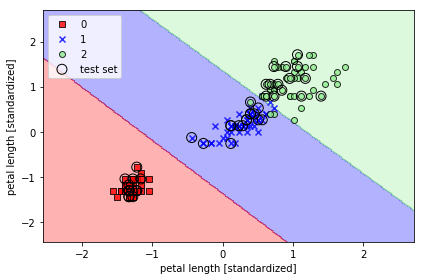

In [23]:
from sklearn.svm import SVC
# 線形SVMのインスタンスを作成
svm = SVC(kernel="linear", C=1.0, random_state=1)
# 線形SVMのモデルにトレーニングデータを適合させる
svm.fit(X_train_std, y_train)
plot_decision_regions(X_combined_std, y_combined, classifier=svm,
                                        test_idx=range(105, 150))
plt.xlabel("petal length [standardized]")
plt.ylabel("petal length [standardized]")
plt.legend(loc="upper left")
plt.tight_layout()
plt.show()

In [24]:
from sklearn.linear_model import SGDClassifier
ppn = SGDClassifier(loss="perceptron")
lr = SGDClassifier(loss="log")
svm = SGDClassifier(loss="hinge")

## 3.5　カーネルSVMを使った非線形問題の求解

### 3.5.1　線形分離不可能なデータに対するカーネル手法

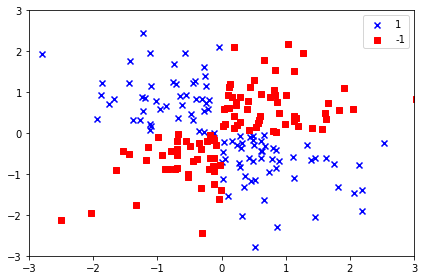

In [25]:
import matplotlib.pyplot as plt
import numpy as np
# 乱数シードを指定
np.random.seed(1)
# 標準正規分布に従う乱数で200行2列の行列を生成
X_xor = np.random.randn(200, 2)
# 2つの引数に対して排他的論理和を実行
y_xor = np.logical_xor(X_xor[:, 0] > 0, X_xor[:, 1] > 0)
# 排他的論理和の値が真の場合は1、偽の場合は-1を割当
y_xor = np.where(y_xor, 1, -1)
# ラベル1を青のxでプロット
plt.scatter(X_xor[y_xor==1, 0], X_xor[y_xor==1, 1],
                    c="b", marker="x", label="1")
# ラベル-1を赤の四角でプロット
plt.scatter(X_xor[y_xor==-1, 0], X_xor[y_xor==-1, 1],
                    c="r", marker="s", label="-1")
# 軸の範囲を設定
plt.xlim([-3, 3])
plt.ylim([-3, 3])
plt.legend(loc="best")
plt.tight_layout()
plt.show()

### 3.5.2　カーネルトリックを使って分離超平面を高次元空間で特定する

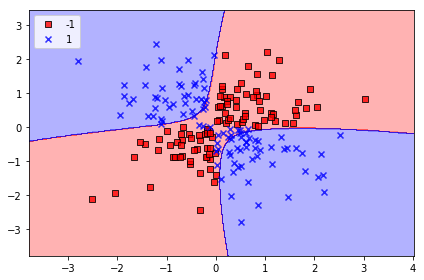

In [26]:
# RBFカーネルによるSVMのインスタンスを作成
svm = SVC(kernel="rbf", random_state=1, gamma=0.10, C=10.0)
svm.fit(X_xor, y_xor)
plot_decision_regions(X_xor, y_xor, classifier=svm)
plt.legend(loc="upper left")
plt.tight_layout()
plt.show()

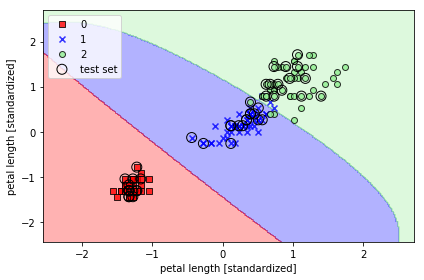

In [27]:
# RBFカーネルによるSVMのインスタンスを作成（2つのパラメータをを変更）
svm = SVC(kernel="rbf", random_state=1, gamma=0.2, C=1.0)
svm.fit(X_train_std, y_train)
plot_decision_regions(X_combined_std, y_combined, classifier=svm,
                                        test_idx=range(105, 150))
plt.xlabel("petal length [standardized]")
plt.ylabel("petal length [standardized]")
plt.legend(loc="upper left")
plt.tight_layout()
plt.show()

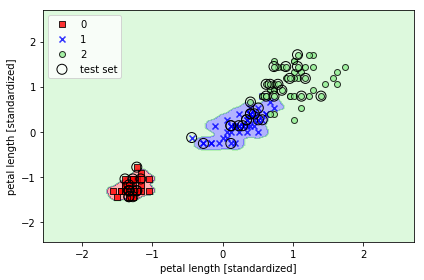

In [28]:
# RBFカーネルによるSVMのインスタンスを作成（γパラメータをを変更）
svm = SVC(kernel="rbf", random_state=1, gamma=100.0, C=1.0)
svm.fit(X_train_std, y_train)
plot_decision_regions(X_combined_std, y_combined, classifier=svm,
                                        test_idx=range(105, 150))
plt.xlabel("petal length [standardized]")
plt.ylabel("petal length [standardized]")
plt.legend(loc="upper left")
plt.tight_layout()
plt.show()

## 3.6　決定木学習

### 3.6.1　情報利得の最大化：できるだけ高い効果を得る

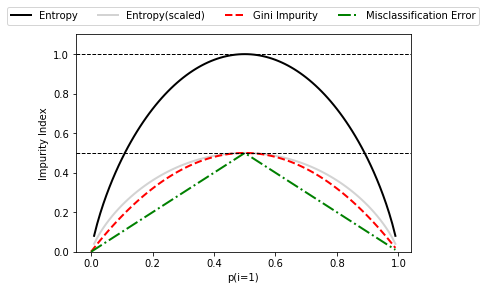

In [29]:
import matplotlib.pyplot as plt
import numpy as np
# ジニ不純度の関数の定義
def gini(p):
    return (p)* (1 - (p)) + (1 - p)*(1 - (1 - p))

# エントロピーの関数を定義
def entropy(p):
    return -p*np.log2(p) - (1 - p)*np.log2((1 - p))

# 分類誤差の関数を定義
def error(p):
    return 1 - np.max([p, 1 - p])

# 確率を表す配列を生成（0から0.99まで0.01刻み）
x = np.arange(0.0, 1.0, 0.01)
# 配列の値をもとにエントロピー、分類誤差を計算
ent = [entropy(p) if p != 0 else None for p in x]
sc_ent = [e*0.5 if e else None for e in ent]
err = [error(i) for i in x]
# 図の作成
fig = plt.figure()
ax = plt.subplot(111)
# エントロピー（2種）、ジニ不純度、分類誤差のそれぞれをループ処理
for i, lab, ls, c in zip([ent, sc_ent, gini(x), err],
                                   ["Entropy", "Entropy(scaled)",
                                   "Gini Impurity", "Misclassification Error"],
                                   ["-", "-", "--", "-."],
                                   ["black", "lightgray", "red", "green", "cyan"]):
    line = ax.plot(x, i, label=lab, linestyle=ls, lw=2, color=c)

# 凡例の設定（中央の上に配置）
ax.legend(loc="upper center", bbox_to_anchor=(0.5, 1.15),
                  ncol=5, fancybox=True, shadow=False)
# 2本の水破線を引く
ax.axhline(y=0.5, linewidth=1, color="k", linestyle="--")
ax.axhline(y=1.0, linewidth=1, color="k", linestyle="--")
# 横軸の上限・下限を設定
plt.ylim([0, 1.1])
plt.xlabel("p(i=1)")
plt.ylabel("Impurity Index")
plt.show()

### 3.6.2　決定木の構築

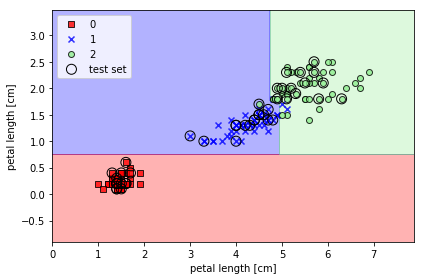

In [32]:
from sklearn.tree import DecisionTreeClassifier
# ジニ不純度を指標とする決定木のインスタンスの作成
tree = DecisionTreeClassifier(criterion="gini", max_depth=4, random_state=1)
# 決定木のモデルをトレーニングデータに適合させる
tree.fit(X_train, y_train)
X_combined = np.vstack((X_train, X_test))
y_combined = np.hstack((y_train, y_test))
plot_decision_regions(X_combined, y_combined, classifier=tree,
                                        test_idx=range(105, 150))
plt.xlabel("petal length [cm]")
plt.ylabel("petal length [cm]")
plt.legend(loc="upper left")
plt.tight_layout()
plt.show()

In [36]:
from pydotplus import graph_from_dot_data
from sklearn.tree import export_graphviz
dot_data = export_graphviz(tree,
                                                   filled=True,
                                                   rounded=True,
                                                   class_names=["Setosa", "Versicolor", "Virginica"],
                                                   feature_names=["petal length", "petal width"],
                                                   out_file=None)
graph = graph_from_dot_data(dot_data)
graph.write_png("tree.png")

True

### 3.6.3　ランダムフォレストを使って複数の決定木を結合する

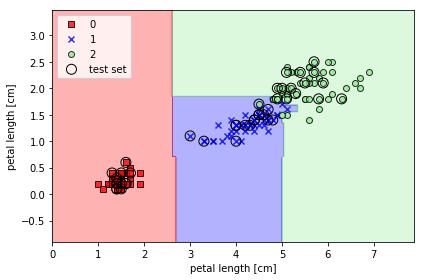

In [37]:
from sklearn.ensemble import RandomForestClassifier
# ジニ不純度を指標とするランダムフォレストのインスタンスを生成
forest = RandomForestClassifier(criterion="gini",
                                                         n_estimators=25, random_state=1, n_jobs=2)
# トレーニングデータにランダムフォレストのモデルを適合させる
forest.fit(X_train, y_train)
plot_decision_regions(X_combined, y_combined, classifier=forest,
                                        test_idx=range(105, 150))
plt.xlabel("petal length [cm]")
plt.ylabel("petal length [cm]")
plt.legend(loc="upper left")
plt.tight_layout()
plt.show()

## 3.7　k近傍法：怠惰学習アルゴリズム

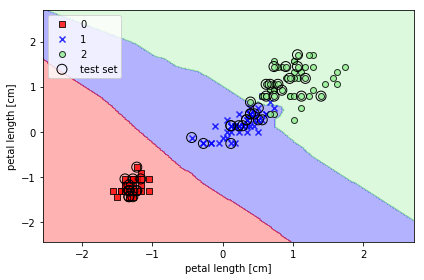

In [38]:
from sklearn.neighbors import KNeighborsClassifier
# k近傍法のインスタンスを生成
knn = KNeighborsClassifier(n_neighbors=5, p=2, metric="minkowski")
knn.fit(X_train_std, y_train)
plot_decision_regions(X_combined_std, y_combined, classifier=knn,
                                        test_idx=range(105, 150))
plt.xlabel("petal length [cm]")
plt.ylabel("petal length [cm]")
plt.legend(loc="upper left")
plt.tight_layout()
plt.show()